# Project: No-show Appointments Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this dataset we are presented with information from 100k medical appointments in Brazil, including a very important metric: whether they show up to their scheduled appointment or not. Information about the patients is included in the different columns such as age, gender, appointment and scheduling days.
>
> We will be exploring the dataset to answer the following question:
> What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set_style('darkgrid')
plt.rc('figure', figsize=(15, 7.5))

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
#Load dataset and preview 

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [3]:
#Checking the type of the data provided in addition to the null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
#Some statistics that would make the wrangling process easier, checking if there are any wrong/impossible values

df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [5]:
#Checking for duplicate values of Patient

sum(df['PatientId'].duplicated())

48228

In [6]:
#Checking for duplicate values in appointments

sum(df['AppointmentID'].duplicated())

0

### Initial Notes on the Dataset

It seems like the dataset contains originally 110527 entries and 14 columns. There are no null-values in the dataset. 

There are duplicate patient ID entries but no duplicate appointment ID, therefore same patients could have different appointments. 

The column AppointmentID will not be useful for us and hence would be dropped.
The ScheduledDay and AppointmentDay columns are of the type string and need to be converted to datetime for easier handling. 
From the Age column we see that we need to clean the data in order to have valid ages (the minimum is -1). 


### Data Cleaning
Cleaning the data will consist of:

- Ranking appointment numbers per patient using PatientId and AppointmentDay
- Extracting the number of days between scheduling and appointment days, in addition to making sure results are coherent.
- Removing the invalid values in the Age column.
- Dropping the AppointmentID, ScheduledDay and AppointmentDay column.

In [7]:
# Ranking appointment numbers per patient

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['AppointmentNum'] = df.groupby('PatientId')['AppointmentDay'].rank(method='first')

In [8]:
#Getting the number of days between scheduling and appointment day by converting the columns to datetime first then subtracting them

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date

df['DaysElapsed'] = df['AppointmentDay'] - df['ScheduledDay']


It seems like DaysElapsed contains negative days, we will fix this by changing all negative values to 0.

In [9]:
#Setting negative elapsed days to 0

zero = datetime.timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
df.loc[df['DaysElapsed'] < zero, 'DaysElapsed'] = zero

In [10]:
#removing the Age value that is less than 0

df.drop(df.index[df['Age']< 0], axis = 0, inplace = True)

In [11]:
#Dropping unnecessary columns such as AppointmentID that will not be useful for the analysis in addition to changing the name of No-show to No_Show

df.drop(columns = ['AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis =1, inplace = True)
df.rename(columns ={'No-show':'NoShow'}, inplace=True)

### Final Check on Data

In [12]:
df.head()

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,AppointmentNum,DaysElapsed
0,2.987250e+13,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1.0,0 days
1,5.589978e+14,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1.0,0 days
2,4.262962e+12,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,1.0,0 days
3,8.679512e+11,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1.0,0 days
4,8.841186e+12,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1.0,0 days


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   PatientId       110526 non-null  float64        
 1   Gender          110526 non-null  object         
 2   Age             110526 non-null  int64          
 3   Neighbourhood   110526 non-null  object         
 4   Scholarship     110526 non-null  int64          
 5   Hipertension    110526 non-null  int64          
 6   Diabetes        110526 non-null  int64          
 7   Alcoholism      110526 non-null  int64          
 8   Handcap         110526 non-null  int64          
 9   SMS_received    110526 non-null  int64          
 10  NoShow          110526 non-null  object         
 11  AppointmentNum  110526 non-null  float64        
 12  DaysElapsed     110526 non-null  timedelta64[ns]
dtypes: float64(2), int64(7), object(3), timedelta64[ns](1)
memory usage: 11.8+

In [14]:
df.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AppointmentNum,DaysElapsed
count,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526
mean,1.474934e+14,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,2.270326,10 days 04:24:47.606536018
std,2.560943e+14,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,3.913435,15 days 06:07:08.735682534
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00
25%,4.172536e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4 days 00:00:00
75%,9.438963e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,15 days 00:00:00
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,88.000000,179 days 00:00:00


> We have cleaned the data. 
The dataset now consists of 13 columns and 110526, after dropping unnecessary columns and an invalid age value.

> **Data is now ready to be explored!**

<a id='eda'></a>
## Exploratory Data Analysis

### What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

In [15]:
# We will be first creating different dataframes for rows of patients that are no-show and showed up to make the analysis easier
df_no_show = df.query('NoShow == "Yes"')
df_showed_up = df.query('NoShow == "No"')

In [16]:
df_no_show.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,AppointmentNum,DaysElapsed
count,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319
mean,1.467523e+14,34.317667,0.115507,0.169004,0.064071,0.030333,0.020297,0.438371,2.120346,15 days 19:57:59.349433218
std,2.549905e+14,21.965941,0.319640,0.374764,0.244885,0.171505,0.156670,0.496198,2.389438,16 days 14:31:49.205336168
min,5.628261e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00
25%,4.176779e+12,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4 days 00:00:00
50%,3.156794e+13,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11 days 00:00:00
75%,9.454270e+13,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,23 days 00:00:00
max,9.996585e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,78.000000,179 days 00:00:00


In [17]:
#Create a function to take the title and labels of a plot
def plot_format(metric, xlabel, ylabel):
    plt.title('Relationship between {} and showing-up to drs appointment'.format(metric));
    plt.xlabel('{}'.format(xlabel));
    plt.ylabel('{}'.format(ylabel));
    plt.legend(loc='upper right');

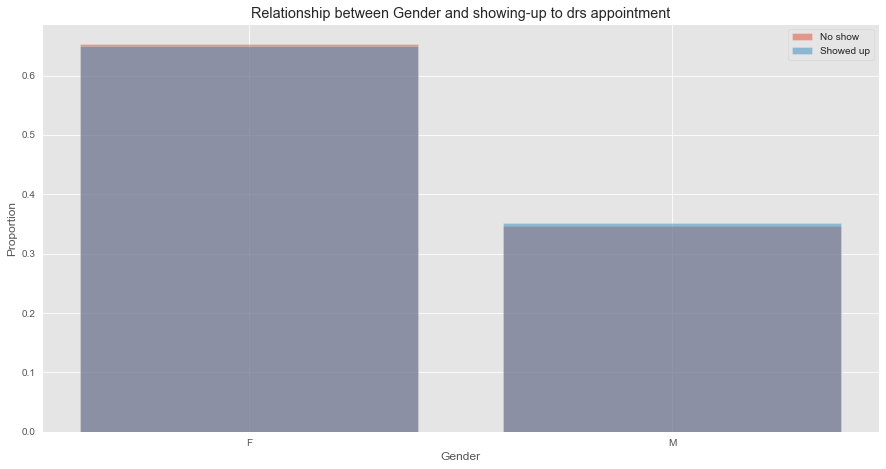

In [18]:
# Exploring whether Gender has an effect on not showing up. 
# We are plotting proportions for the analysis to be comparable


X = ['F', 'M']
plt.style.use('ggplot')
plt.bar(X, (df_no_show['Gender'].value_counts()/df_no_show['Gender'].count()), alpha=0.5, label="No show");
plt.bar(X, (df_showed_up['Gender'].value_counts()/df_showed_up['Gender'].count()), alpha=0.5, label="Showed up");
plot_format('Gender', 'Gender', 'Proportion')

It seems like gender does not affect the probability of showing up or not showing up to your appointment. 
The proportions are very close for showing up and not showing up. 

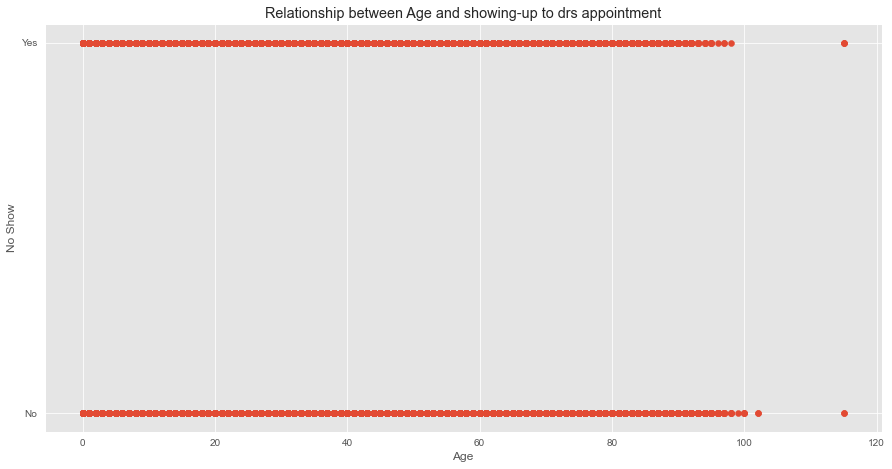

In [19]:
# Exploring the relationship between Age and showing up to drs appointment

plt.style.use('ggplot')
plt.scatter(df['Age'],df['NoShow']);
plt.title('Relationship between Age and showing-up to drs appointment');
plt.xlabel('Age');
plt.ylabel('No Show');

From the above scatter plot, we cannot observe any changes in the age distributions for patients who show up and those who miss their appointments, we cannot make any predictions. The only observation is that there are older people showing up to their appointments as seen by the datapoints after 100 years. To have a better analysis, we are going to plot the different age distributions in histograms to compare both. 


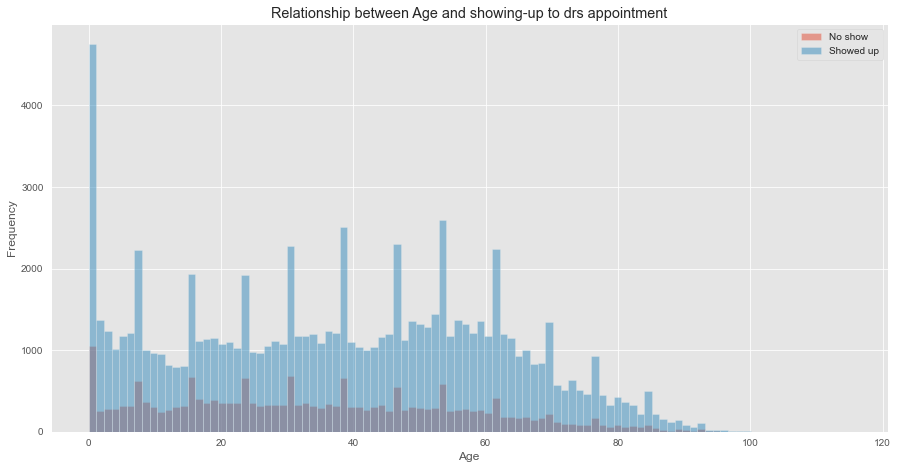

In [20]:
# Exploring whether Age has an effect on not showing up


plt.style.use('ggplot')
plt.hist(df_no_show['Age'], bins=100, alpha=0.5, label="No show");
plt.hist(df_showed_up['Age'], bins=100, alpha=0.5,label= "Showed up");
plot_format('Age', 'Age', 'Frequency')

From the histograms above, we observe that babies between the ages of 0-5 years are more likely to show up to their appointments. We can also see that old people between the ages of 60-80 tend to miss more appointments than adults from 20 to 60. 

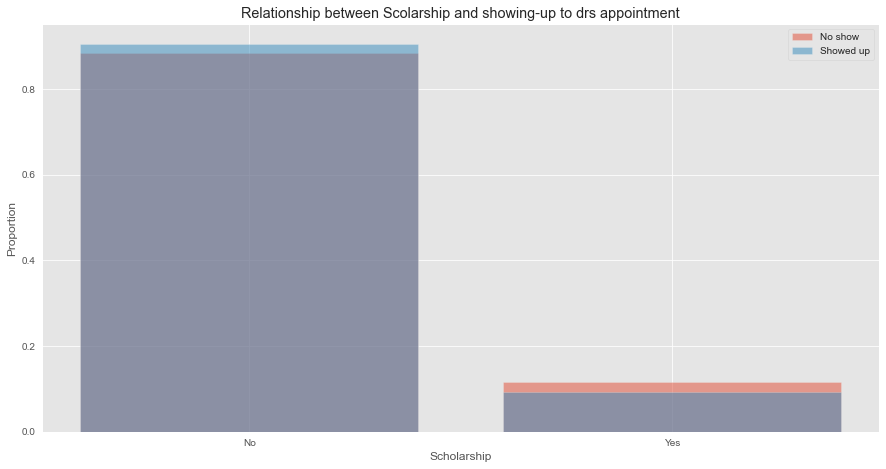

In [21]:
# Exploring whether scholarship affects showing up to appointment

X = ['No', 'Yes']
plt.style.use('ggplot')
plt.bar(X, (df_no_show['Scholarship'].value_counts()/df_no_show['Scholarship'].count()), alpha=0.5, label="No show");
plt.bar(X, (df_showed_up['Scholarship'].value_counts()/df_showed_up['Scholarship'].count()), alpha=0.5, label="Showed up");
plot_format('Scolarship', 'Scholarship', 'Proportion')

From the bar charts above, we observe that individuals with scholarship are slightly more likely to miss their appointments than individuals without scholarship. But the proportions are very close.

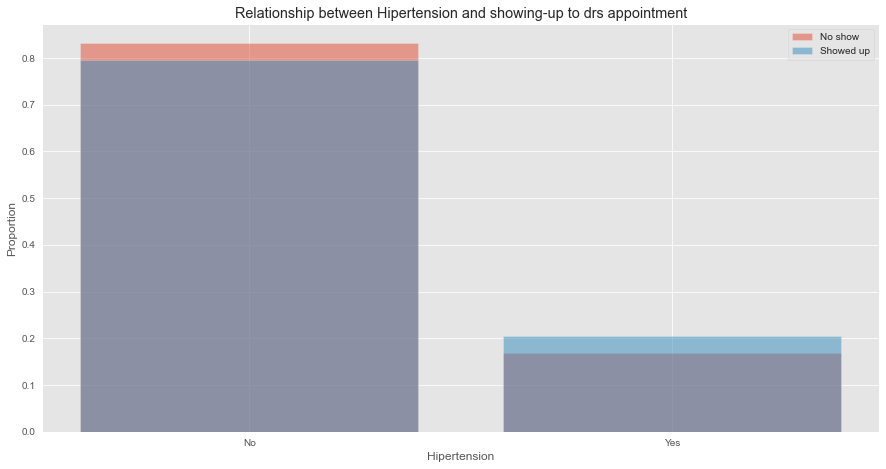

In [22]:
# Exploring whether individuals with hipertension miss more appointments or not

X = ['No', 'Yes']
plt.style.use('ggplot')
plt.bar(X, (df_no_show['Hipertension'].value_counts()/df_no_show['Hipertension'].count()), alpha=0.5, label="No show");
plt.bar(X, (df_showed_up['Hipertension'].value_counts()/df_showed_up['Hipertension'].count()), alpha=0.5, label="Showed up");
plot_format('Hipertension', 'Hipertension', 'Proportion')

From the bar charts, we can see that patients with hipertension tend to show up more to their appointments.

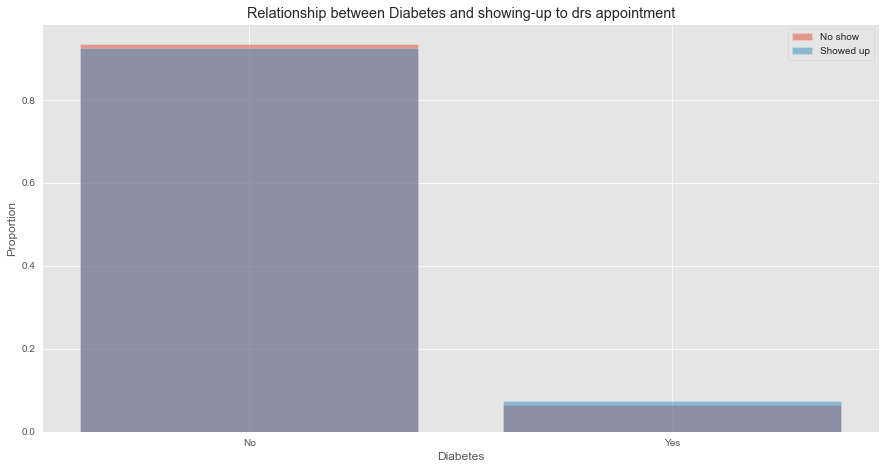

In [23]:
# Exploring whether individuals with hipertension miss more appointments or not

X = ['No', 'Yes']
plt.style.use('ggplot')
plt.bar(X, (df_no_show['Diabetes'].value_counts()/df_no_show['Diabetes'].count()), alpha=0.5, label="No show");
plt.bar(X, (df_showed_up['Diabetes'].value_counts()/df_showed_up['Diabetes'].count()), alpha=0.5, label="Showed up");
plot_format('Diabetes', 'Diabetes', 'Proportion')

From the bar chart, we can observe that Diabetes does not affect showing up to your appointment.

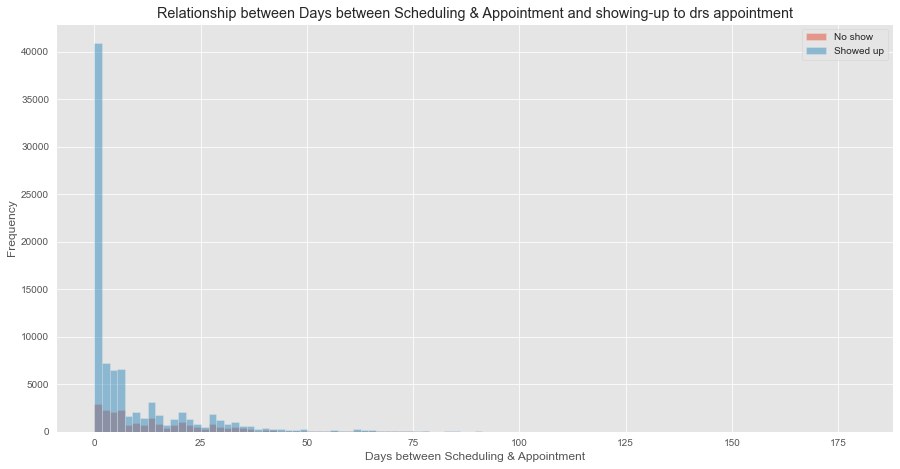

In [24]:
# Exploring whether days between scheduling and appointment day has an effect on not showing up
# To be able to plot we convert the type of DaysElapsed to show only the days count

plt.style.use('ggplot')
plt.hist(df_no_show['DaysElapsed'].astype('timedelta64[D]'), bins=100, alpha=0.5, label="No show");
plt.hist(df_showed_up['DaysElapsed'].astype('timedelta64[D]'), bins=100, alpha=0.5,label= "Showed up");
plot_format('Days between Scheduling & Appointment', 'Days between Scheduling & Appointment', 'Frequency')

From the above histogram, we can observe that patients are more likely to show up at their appointment if there are less days between scheduling and appointment day (0-4 days). 

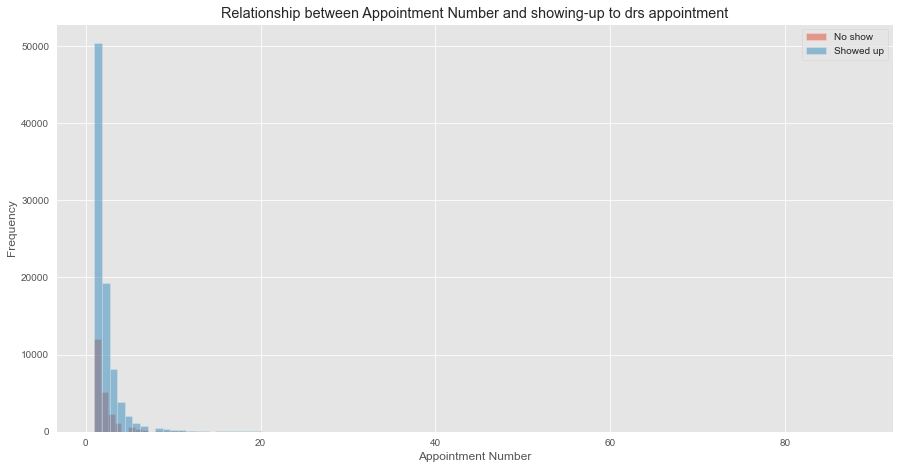

In [25]:
# Exploring whether appointment number correlates with higher show ups or not

plt.style.use('ggplot')
plt.hist(df_no_show['AppointmentNum'], bins=100, alpha=0.5, label="No show");
plt.hist(df_showed_up['AppointmentNum'], bins=100, alpha=0.5,label= "Showed up");
plot_format('Appointment Number', 'Appointment Number', 'Frequency')

From the above histogram, we can observe that patients are more likely to show up to their first appointments.

<a id='conclusions'></a>
## Conclusions

From the small analysis we conducted, we can conclude the following:
- Gender, Scholarship and Diabetes do not seem to be correlated with higher show-ups to appointments. 
- Age is correlated with show-ups: we observed that babies between the ages of ~0-5 year olds have reported lower missed appointments in addition to old people (60+). 
- Patients suffering from Hypertension have missed fewer appointments.
- We can conclude that there is a correlation between the number of days between scheduling & appointment day and missing the appointment: patients miss much fewer appointments when they schedule on the same day of the appointment. 
- Lastly, patients usually attend their first appointments more than their subsequent ones. 

This analysis is definitely incomplete and can include more metrics and complex analysis but due to time, I was limited to the above analysis. 